<a href="https://colab.research.google.com/github/TonyKimisintheHouse/Self-Study-ML-Fundamentals-and-DL/blob/master/benjamin-franklin/PRML_Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRML Chapter 3

In [0]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def generate_toy_sample(func, sample_size, std):
  x = np.linspace(0, 1, sample_size)
  y = func(x) + np.random.normal(scale=std, size=x.shape)
  return x, y

In [0]:
class GaussianFeature(object):
  """
  Gaussian feature

  gaussian function = exp
  """
  def __init__(self, mean, var):
    """
    Construct Gaussian Features
    """

    self.mean = mean
    self.var = var

  def _gauss(self, x, mean):
    return np.exp(-0.5 * np.sum(np.square(x - mean), axis=-1) / self.var)

  def transform(self, x):
    if x.ndim == 1:
      x = x[:,None]
    else:
      assert x.ndim == 2

    basis = [np.ones(len(x))]
    for m in self.mean:
      basis.append(self._gauss(x, m))
    return np.asarray(basis).transpose()

In [0]:
class LinearRegression(object):


  def fit(self, X_train, Y_train):
    self.w = np.linalg.pinv(X_train) @ Y_train
    self.var = np.mean(np.square(X_train @ self.w - Y_train))
  def predict(self, X, return_std=False):
    y = X @ self.w
    if return_std:
      y_std = np.sqrt(self.var) + np.zeros_like(y)
      return y, y_std
    return y

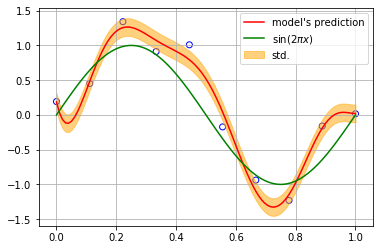

In [41]:
def sinosoidal(x):
  return np.sin(2* np.pi * x)


x_train, y_train = generate_toy_sample(sinosoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinosoidal(x_test)


gaussian = GaussianFeature(np.linspace(0, 1, 8), 0.1)

X_train = gaussian.transform(x_train)
X_test = gaussian.transform(x_test)

model = LinearRegression()
model.fit(X_train, y_train)
y, y_std = model.predict(X_test, return_std=True)

plt.scatter(x_train, y_train, facecolor="None", edgecolors="b")
plt.plot(x_test, y, color="r", label="model's prediction")
plt.plot(x_test, y_test, color="g", label="$\sin(2\pi x)$")
plt.fill_between(
    x_test, y - y_std, y + y_std,
    color="orange", alpha=0.5, label="std."
)
plt.legend()
plt.grid()
plt.show()

## Bayesian Regression

In [0]:
class BayesianRegression(object):
  """
  w ~ N(w|0, alpha^(-1)I)
  y = X @ w
  t ~ N(t|X @ w, beta^(-1))
  """

  def __init__(self, alpha:float=1., beta:float=1.):
    self.alpha = alpha
    self.beta = beta
    self.w_mean = None
    self.w_precision = None

  def _is_prior_defined(self):
    return self.w_mean is not None and self.w_precision is not None

  def _get_prior(self, ndim:int) -> tuple:
    if self._is_prior_defined():
      return self.w_mean, self.w_precision

    else:
      return np.zeros(ndim), self.alpha * np.eye(ndim) #p(w|alpha) = N(w|0, inv(alpha)I) Making each weight independent by making it a diagonal matrix


  def fit(self, X:np.ndarray, t:np.ndarray):
    """
    Bayesian update of parametesr given training dataset
    """

    mean_prev, precision_prev = self._get_prior(np.size(X, 1))
    
    w_precision = precision_prev + self.beta * X.T @ X #alpha I + beta X.T @ X
    w_mean = np.linalg.solve(
        w_precision,
        precision_prev @ mean_prev + self.beta * X.T @ t
    )

    self.w_mean = w_mean
    self.w_precision = w_precision
    self.w_cov = np.linalg.inv(self.w_precision)


  def predict(self, X:np.ndarray, return_std:bool=False, sample_size:int=None):
    if sample_size is not None:
      w_sample = np.random.multivariate_normal(
          self.w_mean, self.w_cov, size=sample_size
      )
      y_sample = X @ w_sample.T
      return y_sample

    y = X @ self.w_mean
    if return_std:
      y_var = 1 / self.beta + 

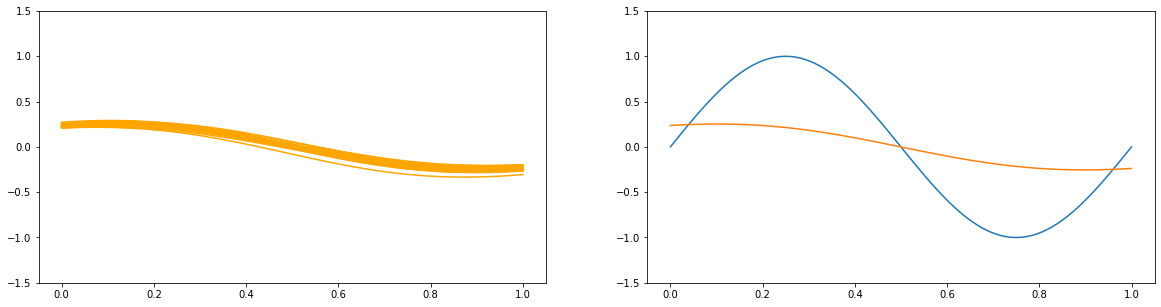

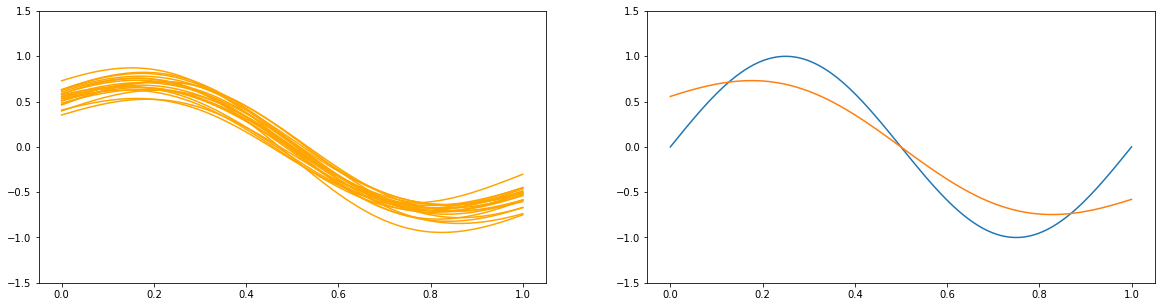

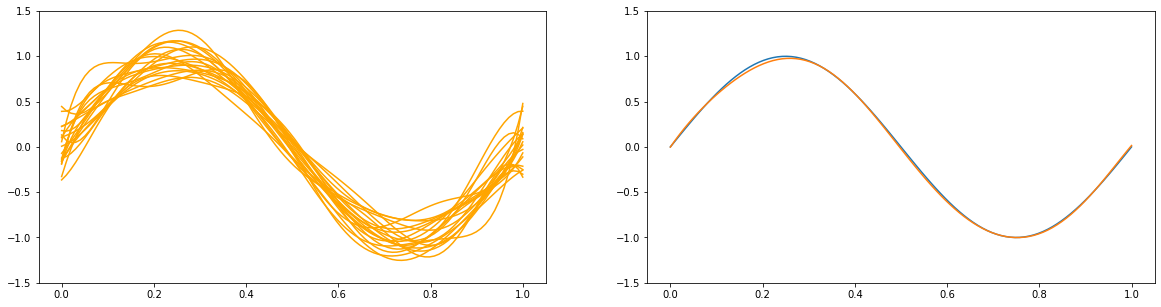

In [57]:
feature = GaussianFeature(np.linspace(0, 1, 24), 0.1)

for a in [1e2, 1., 1e-9]:
  y_list = []
  plt.figure(figsize=(20, 5))
  plt.subplot(1, 2, 1)
  for i in range(100):
      x_train, y_train = generate_toy_sample(sinosoidal, 25, 0.25)
      X_train = feature.transform(x_train)
      X_test = feature.transform(x_test)
      model = BayesianRegression(alpha=a, beta=1.)
      model.fit(X_train, y_train)
      y = model.predict(X_test)
      y_list.append(y)
      if i < 20:
          plt.plot(x_test, y, c="orange")
  plt.ylim(-1.5, 1.5)
  
  plt.subplot(1, 2, 2)
  plt.plot(x_test, y_test)
  plt.plot(x_test, np.asarray(y_list).mean(axis=0))
  plt.ylim(-1.5, 1.5)
  plt.show()

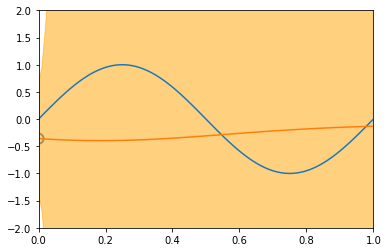

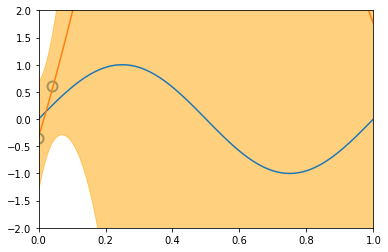

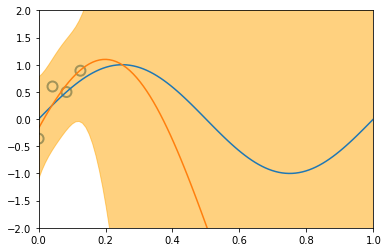

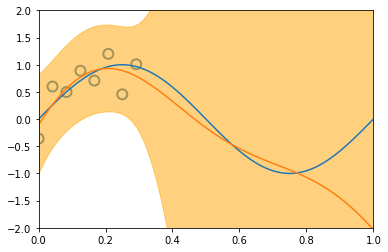

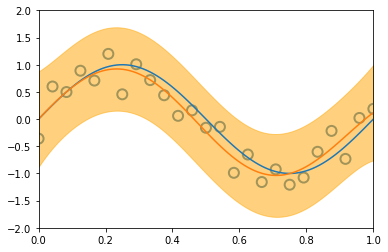

In [60]:
x_train, y_train = generate_toy_sample(sinosoidal, 25, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinosoidal(x_test)

feature = GaussianFeature(np.linspace(0, 1, 9), 0.1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = BayesianRegression(alpha=1e-3, beta=2.)

for begin, end in [[0, 1], [1, 2], [2, 4], [4, 8], [8, 25]]:
    model.fit(X_train[begin: end], y_train[begin: end])
    y, y_std = model.predict(X_test, return_std=True)
    
    
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=2)
    plt.plot(x_test, y_test)
    plt.plot(x_test, y)
    plt.fill_between(x_test, y - y_std, y + y_std, color="orange", alpha=0.5)
    plt.xlim(0, 1)
    plt.ylim(-2, 2)
    plt.show()

In [0]:
def linear(x) 